# 3. Slug Test for Confined Aquifer - Multi-well

### Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import timflow.transient as tft

plt.rcParams['figure.figsize'] = [5, 3]

## Introduction and Conceptual Model

This Slug Test, taken from the AQTESOLV examples, was reported in Butler (1998). 

A well (Ln-2) fully penetrates a sandy confined aquifer, with 6.1 m thickness. Additionally, a fully penetrating observation well (Ln-3) is placed 6.45 m away from the test well. The slug displacement is 2.798 m. Head change was recorded at the slug well and the observation well. The well and casing radii of the slug well are 0.102 and 0.051 m, respectively. For the observation well, they are 0.051 and 0.025 m, respectively.

<img src="./figs/Multi_well.png" style="width:400pt">

### Load data

In [6]:
data1 = np.loadtxt("data/ln-2.txt")
t1 = data1[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h1 = data1[:, 1]

data2 = np.loadtxt("data/ln-3.txt")
t2 = data2[:, 0] / 60 / 60 / 24
h2 = data2[:, 1]

### Parameters and model

In [9]:
# known parameters
H0 = 2.798  # initial displacement, m
b = -6.1  # aquifer thickness, m
rw1 = 0.102  # well radius of Ln-2 Well, m
rw2 = 0.071  # well radius of observation Ln-3 Well, m
rc1 = 0.051  # casing radius of Ln-2 Well, m
rc2 = 0.025  # casing radius of Ln-3 Well, m
r = 6.45  # distance from observation well to test well, m

Converting slug displacement into volume

In [13]:
Q = np.pi * rc1**2 * H0
print("Slug:", round(Q, 5), "m^3")

Slug: 0.02286 m^3


In [16]:
ml = tft.ModelMaq(kaq=10, z=[0, b], Saq=1e-4, tmin=1e-5, tmax=0.01)
w = tft.Well(ml, xw=0, yw=0, rw=rw1, rc=rc1, tsandQ=[(0, -Q)], layers=0, wbstype="slug")
ml.solve()

self.neq  1
solution complete


### Estimate aquifer parameters
The hydraulic conductivity and specific storage are calibrated, as in the KGS model (Hyder et al. 1994).

In [18]:
# unknown parameters: kaq, Saq
cal = tft.Calibrate(ml)
cal.set_parameter(name="kaq", layers=0, initial=10)
cal.set_parameter(name="Saq", layers=0, initial=1e-4)
cal.seriesinwell(name="Ln-2", element=w, t=t1, h=h1)
cal.series(name="Ln-3", x=r, y=0, layer=0, t=t2, h=h2)
cal.fit()

...................................
Fit succeeded.


In [20]:
display(cal.parameters)
print("RMSE:", cal.rmse())

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq_0_0,0,1.166106,2.927703e-03,0.251067,-inf,inf,10.0000,None,[[1.1661060121106153]]
Saq_0_0,0,0.000009,1.158603e-07,1.234870,-inf,inf,0.0001,None,[[9.382385664277816e-06]]


RMSE: 0.010236345953569054


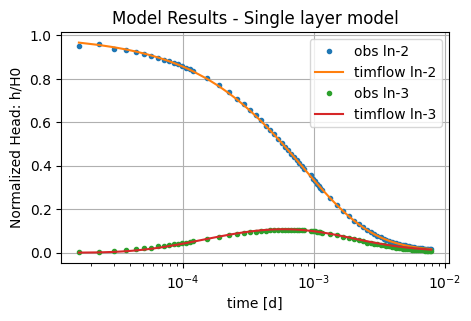

In [33]:
hm1 = w.headinside(t1)
hm2 = ml.head(r, 0, t2, layers=0)
plt.semilogx(t1, h1 / H0, ".", label="obs ln-2")
plt.semilogx(t1, hm1[0] / H0, label="timflow ln-2")
plt.semilogx(t2, h2 / H0, ".", label="obs ln-3")
plt.semilogx(t2, hm2[0] / H0, label="timflow ln-3")
plt.xlabel("time [d]")
plt.ylabel("Normalized Head: h/H0")
plt.title("Model Results - Single layer model")
plt.legend()
plt.grid()

### Comparison of results

The values in `timflow` are compared with the KGS analytical model (Hyder et al. 1994) implemented in AQTESOLV (Duffield, 2007), and to the MLU model (Carlson & Randall, 2012). The parameters in every model closely match each other. The error was also very similar.

In [26]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "RMSE [m]"],
    index=["timflow", "AQTESOLV", "MLU"],
)

t.loc["timflow"] = np.append(cal.parameters["optimal"].values, cal.rmse())
t.loc["AQTESOLV"] = [1.166, 9.368e-06, 0.009151]
t.loc["MLU"] = [1.311, 8.197e-06, 0.010373]

t_formatted = t.style.format(
    {"k [m/d]": "{:.2f}", "Ss [1/m]": "{:.2e}",  "RMSE [m]": "{:.3f}"}
)
t_formatted

,k [m/d],Ss [1/m],RMSE [m]
timflow,1.17,9.38e-06,0.010
AQTESOLV,1.17,9.37e-06,0.009
MLU,1.31,8.20e-06,0.010


### References

* Butler Jr., J.J. (1998), The Design, Performance, and Analysis of Slug Tests, Lewis Publishers, Boca Raton, Florida, 252p.
* Carlson F. and Randall J. (2012), MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems, Ground Water 50(4):504–510.
* Duffield, G.M. (2007), AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Hyder, Z., Butler Jr, J.J., McElwee, C.D. and Liu, W. (1994), Slug tests in partially penetrating wells, Water Resources Research 30, 2945–2957.